In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d datamunge/sign-language-mnist
!unzip ./sign-language-mnist.zip

 78% 49.0M/62.6M [00:00<00:00, 50.3MB/s]
100% 62.6M/62.6M [00:00<00:00, 95.9MB/s]
Archive:  ./sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.rcParams['font.size'] = 12
plt.rcParams['lines.color'] ='#000000'
np.random.seed(1234567)

In [4]:
train_path = './sign_mnist_train/sign_mnist_train.csv'
test_path = './sign_mnist_test/sign_mnist_test.csv'

In [5]:
train = pd.read_csv(train_path) # import data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [6]:
print('shape of training data:', train.shape) # (nrow, ncolumn)

''' na count over all rows and columns
first sum = sums over rows, last sum = sums over columns
'''
print('na count:', train.isna().sum().sum())

shape of training data: (27455, 785)
na count: 0


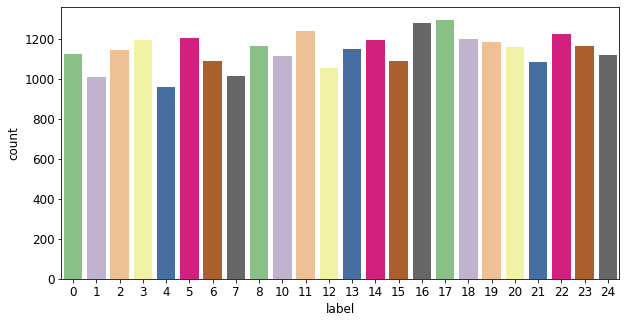

In [7]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=train, palette='Accent')
plt.show()

In [8]:
target_counts = train['label'].value_counts()
target_counts = round(target_counts * 100 / target_counts.sum())
print('majority : minority class ratio =', target_counts.max(), ':', target_counts.min())

majority : minority class ratio = 5.0 : 3.0


In [9]:
X = train.drop('label', axis=1) # features
y = keras.utils.to_categorical(train['label']) # encode target

In [10]:
# reshape square black and white images
def reshape_bw(X):
    samples, width, channel = X.shape[0], int(X.shape[1] ** (1/2)) , 1
    return X.values.reshape(samples, width, width, channel)  

In [11]:
X = reshape_bw(X)
width, height, channel = X.shape[1], X.shape[2], X.shape[3]

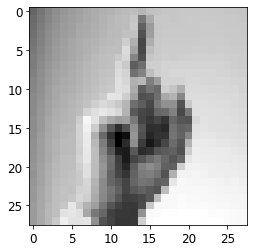

In [12]:
# plot a square black and white image
def plot_image(X, width):
    _ = plt.imshow(X.reshape(width, width), cmap='gray')
    plt.show()
    
plot_image(X[0], width) # plot sample image

In [13]:
# split data into train and validation set with same target distribution as before spliting
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [14]:
# create data preprocessor and fit on train set
generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    height_shift_range=0.15,
    width_shift_range=0.15, 
    fill_mode='nearest'
)
generator.fit(X_train)

In [15]:
# initialize model
def build_baseline_model(func, init):
    keras.backend.clear_session()
    inputs = keras.Input(shape=tuple(X_train.shape[1:]))
    inter = keras.layers.Conv2D(64, (5, 5), padding="same", kernel_initializer=init(), input_shape=(width, height, channel))(inputs)
    inter = keras.layers.BatchNormalization()(inter)
    inter = keras.layers.Activation(func)(inter)
    inter = keras.layers.MaxPooling2D((2, 2))(inter)
    inter = keras.layers.Conv2D(128, (5, 5), padding="same", kernel_initializer=init())(inter)
    inter = keras.layers.BatchNormalization()(inter)
    inter = keras.layers.Activation(func)(inter)
    inter = keras.layers.MaxPooling2D((2, 2))(inter)
    inter = keras.layers.Conv2D(256, (5, 5), padding="same", kernel_initializer=init())(inter)
    inter = keras.layers.BatchNormalization()(inter)
    inter = keras.layers.Activation(func)(inter)
    inter = keras.layers.MaxPooling2D((2, 2))(inter)
    inter = keras.layers.Flatten()(inter)
    outputs = keras.layers.Dense(y.shape[1], activation='softmax')(inter)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

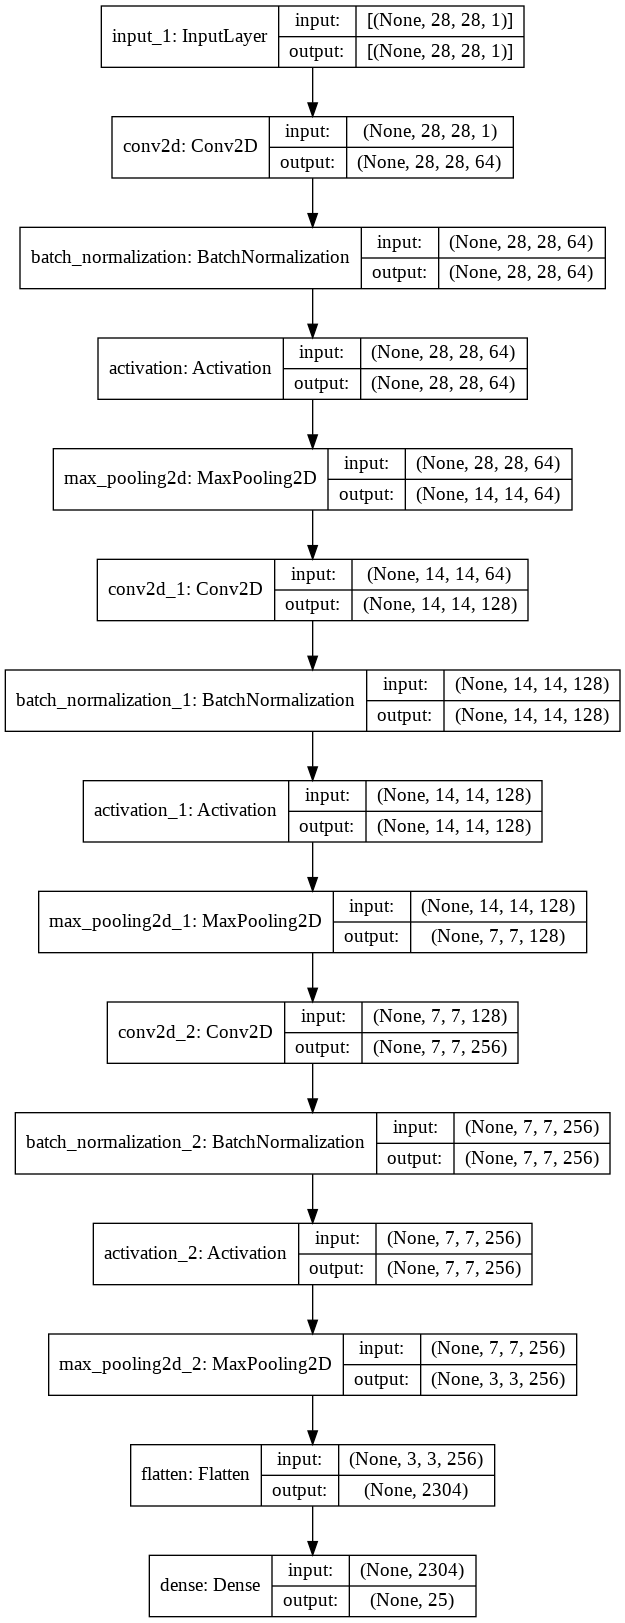

In [16]:
model_elu = build_baseline_model(keras.activations.elu, keras.initializers.glorot_uniform)
# compile model
model_elu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.006),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)
keras.utils.plot_model(model_elu, "model_elu_base.png", show_shapes=True)

In [17]:
# deine model callback
cb_elu = [keras.callbacks.ModelCheckpoint('model_elu_base.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [18]:
history_elu = model_elu.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=12, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_elu,
                    verbose=2)

Epoch 1/12
687/687 - 49s - loss: 1.4495 - accuracy: 0.6623 - precision: 0.7828 - recall: 0.6042 - auc: 0.9422 - val_loss: 0.2201 - val_accuracy: 0.9235 - val_precision: 0.9356 - val_recall: 0.9159 - val_auc: 0.9974
Epoch 2/12
687/687 - 17s - loss: 0.1564 - accuracy: 0.9505 - precision: 0.9590 - recall: 0.9440 - auc: 0.9979 - val_loss: 0.1326 - val_accuracy: 0.9561 - val_precision: 0.9595 - val_recall: 0.9525 - val_auc: 0.9975
Epoch 3/12
687/687 - 16s - loss: 0.0901 - accuracy: 0.9717 - precision: 0.9743 - recall: 0.9696 - auc: 0.9986 - val_loss: 0.1631 - val_accuracy: 0.9587 - val_precision: 0.9610 - val_recall: 0.9567 - val_auc: 0.9951
Epoch 4/12
687/687 - 16s - loss: 0.0868 - accuracy: 0.9748 - precision: 0.9763 - recall: 0.9738 - auc: 0.9983 - val_loss: 0.1328 - val_accuracy: 0.9656 - val_precision: 0.9671 - val_recall: 0.9641 - val_auc: 0.9967
Epoch 5/12
687/687 - 16s - loss: 0.0098 - accuracy: 0.9970 - precision: 0.9973 - recall: 0.9967 - auc: 0.9999 - val_loss: 0.0055 - val_accur

In [19]:
def plot_learning_curve(history):
    ephs = np.arange(0, len(history.history['loss'])) + 1
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(ephs, history.history['accuracy'], '--')
    plt.plot(ephs, history.history['val_accuracy'], '--')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.subplot(1,2,2)
    plt.plot(ephs, history.history['loss'], '--')
    plt.plot(ephs, history.history['val_loss'], '--')
    plt.legend(['loss', 'val_loss'])
    plt.show()

learning curve of baseline model


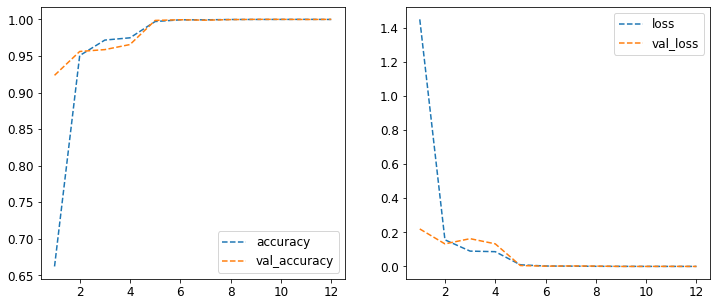

In [20]:
print(f"learning curve of baseline model")
plot_learning_curve(history_elu)

baseline model starts converging at 5th epoch

In [21]:
# evaluate model on unseen data
test = pd.read_csv(test_path)
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


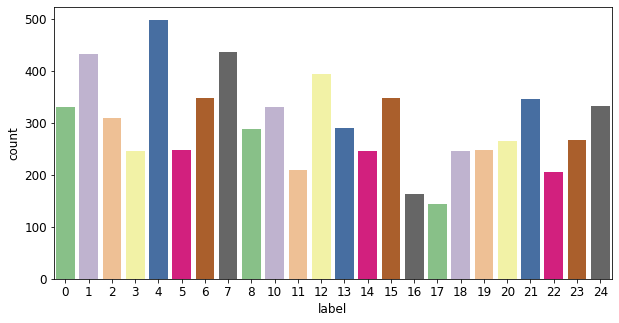

In [22]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(x='label', data=test, palette='Accent')
plt.show()

In [24]:
X_test = test.drop('label', axis=1)
y_test = test['label']
X_test = reshape_bw(X_test)
y_test = keras.utils.to_categorical(y_test)

In [25]:
def evaluate(model):
    loss, acc, pre, rec, auc = model.evaluate(generator.flow(X_test,y_test,batch_size=32))
    print()
    print(f"test loss: {loss}")
    print(f"test accuracy: {round(acc*100,2)} %")
    print(f"test precision: {pre}")
    print(f"test recall: {rec}")
    print(f"test AUC: {auc}")
    print()
    index = int(input("Enter image index: ")) % X_test.shape[0]
    print(f"label: {np.argmax(model.predict(np.expand_dims([X_test[index]], axis=-1), verbose=0))}")
    print(f"actual label: {np.argmax(y_test[index], axis=-1)}")
    plot_image(X_test[index], width)

evaluating baseline model
225/225 [==============================] - 5s 21ms/step - loss: 0.0184 - accuracy: 0.9948 - precision: 0.9953 - recall: 0.9944 - auc: 0.9996

test loss: 0.018448971211910248
test accuracy: 99.48 %
test precision: 0.9952553510665894
test recall: 0.9944227337837219
test AUC: 0.9996325373649597

Enter image index: 1234
label: 4
actual label: 4


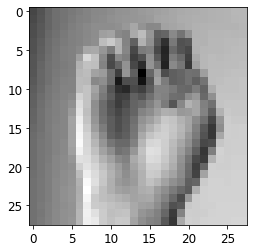

In [26]:
print(f"evaluating baseline model")
evaluate(model_elu)

In [27]:
from sklearn.metrics import confusion_matrix
def plot_confmat(model):   
    cm = confusion_matrix(test['label'], model.predict(X_test).argmax(-1))
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap=plt.cm.Purples)
    plt.ylabel('actual')
    plt.xlabel('predicted')
    plt.show()

confusion matrix of baseline model


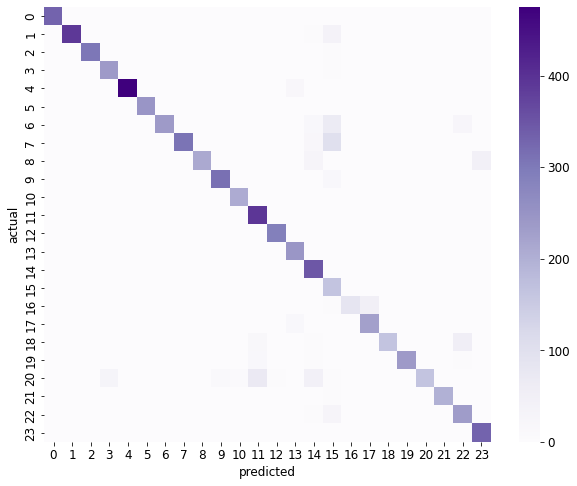

In [28]:
print(f"confusion matrix of baseline model")
plot_confmat(model_elu)

test examples are mostly missclassified to class 15, the overall performance is moderately good

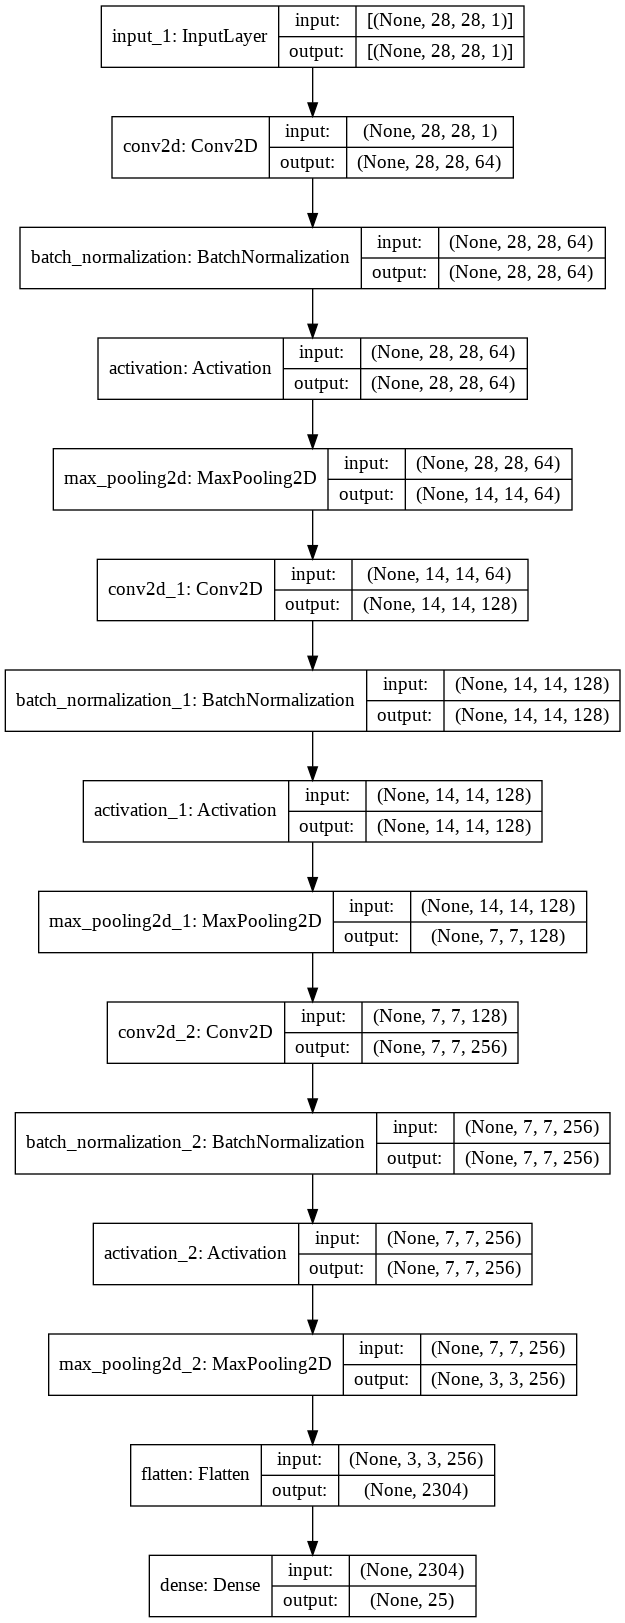

In [29]:
model_elu_2 = build_baseline_model(keras.activations.elu, keras.initializers.he_uniform)
# compile model
model_elu_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.006),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)
keras.utils.plot_model(model_elu_2, "model_elu2_base.png", show_shapes=True)

In [30]:
cb_elu_2 = [keras.callbacks.ModelCheckpoint('model_elu2_base.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [31]:
history_elu_2 = model_elu_2.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=12, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_elu_2,
                    verbose=2)

Epoch 1/12
687/687 - 18s - loss: 1.1704 - accuracy: 0.7241 - precision: 0.8205 - recall: 0.6806 - auc: 0.9574 - val_loss: 0.1510 - val_accuracy: 0.9488 - val_precision: 0.9578 - val_recall: 0.9434 - val_auc: 0.9987
Epoch 2/12
687/687 - 17s - loss: 0.1360 - accuracy: 0.9579 - precision: 0.9634 - recall: 0.9532 - auc: 0.9981 - val_loss: 0.1017 - val_accuracy: 0.9670 - val_precision: 0.9710 - val_recall: 0.9628 - val_auc: 0.9985
Epoch 3/12
687/687 - 16s - loss: 0.0789 - accuracy: 0.9769 - precision: 0.9791 - recall: 0.9748 - auc: 0.9985 - val_loss: 0.0512 - val_accuracy: 0.9862 - val_precision: 0.9872 - val_recall: 0.9851 - val_auc: 0.9993
Epoch 4/12
687/687 - 17s - loss: 0.0789 - accuracy: 0.9777 - precision: 0.9790 - recall: 0.9766 - auc: 0.9983 - val_loss: 0.1559 - val_accuracy: 0.9618 - val_precision: 0.9651 - val_recall: 0.9616 - val_auc: 0.9955
Epoch 5/12
687/687 - 16s - loss: 0.0763 - accuracy: 0.9795 - precision: 0.9807 - recall: 0.9788 - auc: 0.9979 - val_loss: 0.0761 - val_accur

learning curve of model with he uniform initializer


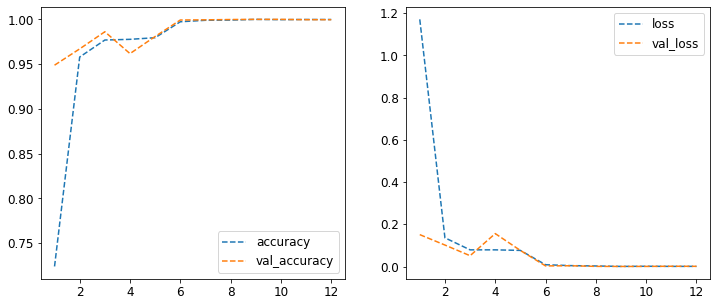

In [32]:
print(f"learning curve of model with he uniform initializer")
plot_learning_curve(history_elu_2)

he uniform took a bit longer to start converging than glorot uniform

evaluating model with he uniform initializer
225/225 [==============================] - 4s 20ms/step - loss: 0.0159 - accuracy: 0.9957 - precision: 0.9958 - recall: 0.9955 - auc: 0.9996

test loss: 0.015885522589087486
test accuracy: 99.57 %
test precision: 0.9958158731460571
test recall: 0.9955381751060486
test AUC: 0.999636173248291

Enter image index: 1005
label: 21
actual label: 21


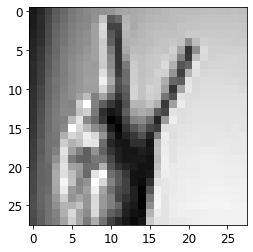

In [33]:
print(f"evaluating model with he uniform initializer")
evaluate(model_elu_2)

confusion matrix of model with he uniform initializer


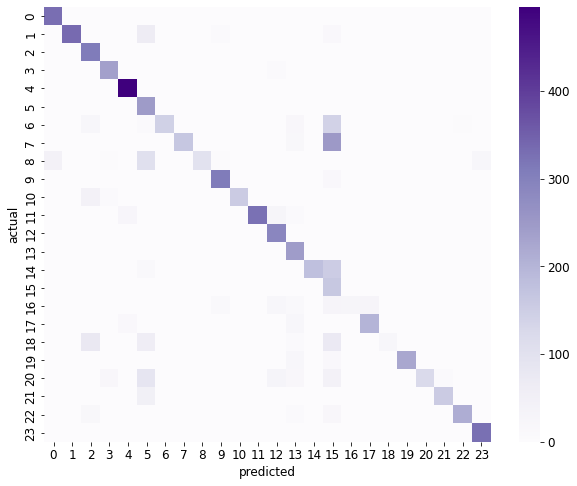

In [34]:
print(f"confusion matrix of model with he uniform initializer")
plot_confmat(model_elu_2)

test examples are mostly missclassified to class 15, he uniform performed better than glorot uniform in overall

In [56]:
def build_reg_model(func, init):
    keras.backend.clear_session()
    reg = keras.regularizers.l2
    inputs = keras.Input(shape=tuple(X_train.shape[1:]))
    inter = keras.layers.Conv2D(64, (5, 5), padding="same", kernel_initializer=init(), input_shape=(width, height, channel))(inputs)
    inter = keras.layers.BatchNormalization()(inter)
    inter = keras.layers.Activation(func)(inter)
    inter = keras.layers.MaxPooling2D((2, 2))(inter)
    inter = keras.layers.Conv2D(128, (5, 5), padding="same", kernel_initializer=init(), kernel_regularizer=reg(l2=1e-4))(inter)
    inter = keras.layers.BatchNormalization()(inter)
    inter = keras.layers.Activation(func)(inter)
    inter = keras.layers.MaxPooling2D((2, 2))(inter)
    inter = keras.layers.Conv2D(256, (5, 5), padding="same", kernel_initializer=init(), kernel_regularizer=reg())(inter)
    inter = keras.layers.BatchNormalization()(inter)
    inter = keras.layers.Activation(func)(inter)
    inter = keras.layers.MaxPooling2D((2, 2))(inter)
    inter = keras.layers.Flatten()(inter)
    outputs = keras.layers.Dense(y.shape[1], activation='softmax')(inter)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [57]:
reg_elu = build_reg_model(keras.activations.elu, keras.initializers.glorot_uniform)
# compile model
reg_elu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.006),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)

In [58]:
# deine model callback
cb_reg_elu = [keras.callbacks.ModelCheckpoint('model_reg_elu.h5', monitor='val_auc', mode='max',save_best_only=True), 
          keras.callbacks.ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, patience=2, min_lr=0.00001)]

In [59]:
history_reg_elu = reg_elu.fit(generator.flow(X_train, y_train, batch_size=32), \
                    epochs=12, \
                    validation_data=generator.flow(X_val,y_val,batch_size=32), \
                    callbacks=cb_reg_elu,
                    verbose=2)

Epoch 1/12
687/687 - 18s - loss: 3.0304 - accuracy: 0.5848 - precision: 0.7070 - recall: 0.5117 - auc: 0.9284 - val_loss: 1.6555 - val_accuracy: 0.8199 - val_precision: 0.8867 - val_recall: 0.7583 - val_auc: 0.9907
Epoch 2/12
687/687 - 17s - loss: 1.5148 - accuracy: 0.8416 - precision: 0.8764 - recall: 0.8100 - auc: 0.9904 - val_loss: 1.1627 - val_accuracy: 0.9057 - val_precision: 0.9308 - val_recall: 0.8824 - val_auc: 0.9962
Epoch 3/12
687/687 - 17s - loss: 1.0643 - accuracy: 0.8970 - precision: 0.9169 - recall: 0.8817 - auc: 0.9950 - val_loss: 1.0316 - val_accuracy: 0.8749 - val_precision: 0.8955 - val_recall: 0.8534 - val_auc: 0.9919
Epoch 4/12
687/687 - 16s - loss: 0.8236 - accuracy: 0.9245 - precision: 0.9377 - recall: 0.9135 - auc: 0.9964 - val_loss: 0.7350 - val_accuracy: 0.9288 - val_precision: 0.9381 - val_recall: 0.9213 - val_auc: 0.9980
Epoch 5/12
687/687 - 17s - loss: 0.7119 - accuracy: 0.9381 - precision: 0.9479 - recall: 0.9307 - auc: 0.9971 - val_loss: 0.8407 - val_accur

learning curve of model with regularization


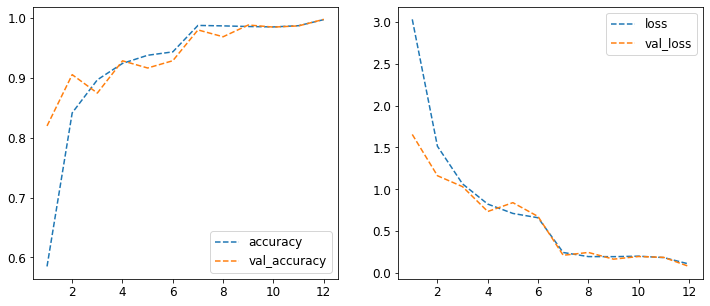

In [60]:
print(f"learning curve of model with regularization")
plot_learning_curve(history_reg_elu)

after some fluctuations, finally the model start to converge at 9 th epoch

evaluating model with regularization
225/225 [==============================] - 4s 20ms/step - loss: 0.0976 - accuracy: 0.9932 - precision: 0.9939 - recall: 0.9921 - auc: 0.9997

test loss: 0.09759664535522461
test accuracy: 99.32 %
test precision: 0.9938538670539856
test recall: 0.992052435874939
test AUC: 0.9997002482414246

Enter image index: 1988
label: 4
actual label: 4


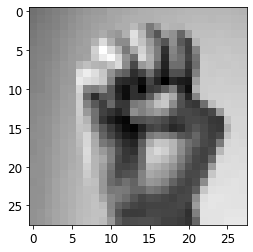

In [63]:
print(f"evaluating model with regularization")
evaluate(reg_elu)

confusion matrix of model with regularization


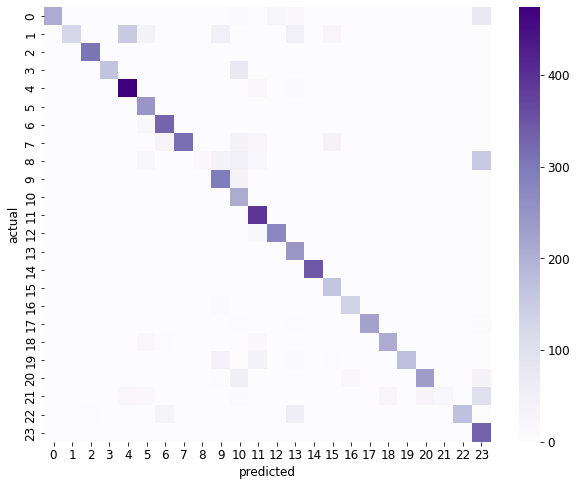

In [64]:
print(f"confusion matrix of model with regularization")
plot_confmat(reg_elu)

regularization did not bring improvements, glorot uniform model without regularization was better

